<a href="https://colab.research.google.com/github/rayrui312/cs349_final/blob/main/CS349Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS349 Final, Stock Trading Using DRL**
By Jingyang Rui

# **Part 1: Install related packages**

In [2]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzf ta-lib-0.4.0-src.tar.gz
%cd ta-lib/
!./configure --prefix=$HOME
!make
!make install
!TA_LIBRARY_PATH=~/lib TA_INCLUDE_PATH=~/include pip install ta-lib
!pip install git+https://github.com/AI4Finance-LLC/ElegantRL.git
!pip install yfinance

--2021-06-06 15:44:53--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-06-06 15:44:53--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2021-06-06 15:44:53--  https://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving phoenixnap

# **Part 2: Import Packages**


*   **ElegantRL**
*   **Yahoo Finance**
*   **TA-Lib**
*   **Numpy**
*   **Pandas**




In [101]:
import yfinance as yf
import numpy as np
import pandas as pd
from elegantrl.agent import *
from elegantrl.run import *
import talib as ta

# **Part 3: Data Fetching and Pre-processing**

Download data from YahooFinance. Then transfer the panda dataframe into numpy array.

In [116]:
def yf_datadownload(start, end, tic_list, interval):
    tics = ' '.join(tic_list)
    data = yf.download(tics, start=start, end=end, interval=interval)
    return data

tic_list1 = ['MSFT']
df = yf_datadownload('2020-01-01', '2021-05-01', tic_list1, '1d')
df = df.dropna(axis=0)
print(df.head())
price_ary = df['Adj Close'].values
price_ary = np.reshape(price_ary,newshape=[price_ary.shape[0],1])
tech_ary = df[['Open','High','Low','Close','Volume']].values



[*********************100%***********************]  1 of 1 completed
                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2020-01-02  158.779999  160.729996  ...  158.205765  22622100
2020-01-03  158.320007  159.949997  ...  156.235825  21116200
2020-01-06  157.080002  159.100006  ...  156.639694  20813700
2020-01-07  159.320007  159.669998  ...  155.211456  21634100
2020-01-08  158.929993  160.800003  ...  157.683731  27746500

[5 rows x 6 columns]


# **Part 4: Define the Environment for DRL**
Reference: https://github.com/AI4Finance-LLC/ElegantRL/blob/master/elegantrl/envs/Stock_Trading_Env.py

In [117]:
class SingleStockEnv:  
    def __init__(self, price_ary, tech_ary, target_return=3.0, initial_account=1e6, stock_unit=1e3, \
                 transaction_fee_percent=1e-3, if_train=True,\
                   gamma = 0.99):
        self.initial_account = initial_account
        self.transaction_fee_percent = transaction_fee_percent
        self.stock_unit = stock_unit
        self.gamma = gamma
        assert price_ary.shape[0] == tech_ary.shape[0]
        n =  price_ary.shape[0]
        if if_train:
            self.price_ary = price_ary[int(0.1*n):int(0.8*n)]
            self.tech_ary = tech_ary[int(0.1*n):int(0.8*n)]
        else:
            self.price_ary = price_ary[int(0.8*n):]
            self.tech_ary = tech_ary[int(0.8*n):]

        # reset
        self.day = 0
        self.account = self.initial_account
        self.day_price = self.price_ary[self.day]
        self.day_tech = self.tech_ary[self.day]
        self.stocks = 0.0  
        self.total_asset = self.account
        self.episode_return = 0.0  
        self.gamma_return = 0.0

        '''env information'''
        self.env_name = 'SingleStockEnv'
        self.state_dim = 2 + self.price_ary.shape[1] + self.tech_ary.shape[1]
        self.action_dim = 4
        self.if_discrete = True
        self.target_return = target_return
        self.max_step = self.price_ary.shape[0]


    def reset(self) -> np.ndarray:
        self.account = self.initial_account
        self.stocks = 0.0
        self.total_asset = self.account
        self.day = 0
        self.day_price = self.price_ary[self.day]
        self.day_tech = self.tech_ary[self.day]

        state = np.hstack((self.account * 2 ** -16, self.day_price * 2 ** -8, 
                           self.day_tech * 2 ** -8, self.stocks * 2 ** -12)).astype(np.float32)
        return state

    def step(self, action):
        price = self.day_price[0]
        if action == 3:
          if self.stocks > 0:
            delta_stock = self.stocks
            self.account += price * delta_stock * (1 - self.transaction_fee_percent)
            self.stocks = 0.0
          else:
            delta_stock = -self.stocks
            self.account -= price * delta_stock * (1 + self.transaction_fee_percent)
            self.stocks = 0.0
        else:
          if action == 0:
              stock_action = 0
          elif action == 1:
              stock_action = 1
          elif action == 2:
              stock_action = -1
          """buy or sell stock"""
          if stock_action == 1:  
              if self.account > self.stock_unit*price*(1 + self.transaction_fee_percent):
                  delta_stock = self.stock_unit
                  self.account -= price * delta_stock * (1 + self.transaction_fee_percent)
                  self.stocks += delta_stock
          elif stock_action == -1: 
              if (self.account)/self.total_asset < 1.8:
                  delta_stock = self.stock_unit
                  self.account += price * delta_stock * (1 - self.transaction_fee_percent)
                  self.stocks -= delta_stock
            
        """update day"""
        self.day += 1
        self.day_price = self.price_ary[self.day]
        self.day_tech = self.tech_ary[self.day]
        done = (self.day+1) == self.max_step  
        state = np.hstack((self.account * 2 ** -16, self.day_price * 2 ** -8, 
                   self.day_tech * 2 ** -8, self.stocks * 2 ** -12)).astype(np.float32)

        next_total_asset = self.account + self.day_price[0]*self.stocks
        reward = (next_total_asset - self.total_asset) * 2 ** -16  
        self.total_asset = next_total_asset
        self.gamma_return = self.gamma_return * self.gamma + reward 
        if done:
            reward += self.gamma_return
            self.gamma_return = 0.0  
            self.episode_return = next_total_asset / self.initial_account  
        return state, reward, done, None
    
    @staticmethod
    def draw_cumulative_return(self, _torch) -> list:
        state_dim = self.state_dim
        action_dim = self.action_dim

        agent = AgentDQN()
        net_dim = 2 ** 9
        cwd = './AgentDQN/SingleStockEnv_0'

        agent.init(net_dim, state_dim, action_dim)
        agent.save_load_model(cwd=cwd, if_save=False)
        act = agent.act
        device = agent.device

        state = self.reset()
        episode_returns = list()
        stock_returns = list()# the cumulative_return / initial_account
        with _torch.no_grad():
            for i in range(self.max_step):
                if i == 0:
                    init_price = self.day_price[0]
                s_tensor = _torch.as_tensor((state,), device=device)
                action = act(s_tensor)[0]  # not need detach(), because with torch.no_grad() outside
                a_int = action.argmax(dim=0).cpu().numpy()
                action = a_int 
                state, reward, done, _ = self.step(action)
                episode_return = self.total_asset / self.initial_account
                episode_returns.append(episode_return)
                stock_return = (self.day_price[0]/init_price)
                stock_returns.append(stock_return)
                if done:
                    break

        import matplotlib.pyplot as plt
        %matplotlib inline
        plt.plot(episode_returns)
        plt.plot(stock_returns, color = 'yellow')
        plt.grid()
        plt.title('cumulative return')
        plt.xlabel('day')
        plt.savefig('/home/cumulative_return.jpg')
        plt.show()
        return 



# **Part 5: Train and Evaluate the Agent**
Reference: https://github.com/AI4Finance-LLC/ElegantRL/

In [119]:
args = Arguments(agent=None, env=None)
args.agent = AgentDQN()
target = price_ary[-1]/price_ary[0]
args.env = SingleStockEnv(price_ary = price_ary, tech_ary = tech_ary,
                          target_return = 1.2,if_train=True)
args.env_eval = SingleStockEnv(price_ary = price_ary, tech_ary = tech_ary,
                          target_return = 1.2,if_train=False)
args.net_dim = 2 ** 9
args.batch_size = 2 ** 8
args.break_step = int(1e5)
train_and_evaluate(args)


| GPU id: 0, cwd: ./AgentDQN/SingleStockEnv_0
| Remove history
ID      Step      MaxR |    avgR      stdR       objA      objC |  avgS  stdS
0   1.02e+03      1.07 |
0   1.02e+03      1.07 |    1.07      0.00     757.11  46908.95 |    66     0
0   8.19e+03      1.07 |    1.00      0.00     297.95   7564.22 |    66     0
0   1.54e+04      1.07 |    1.07      0.00      87.50    598.34 |    66     0
0   2.25e+04      1.07 |    1.07      0.00      26.99     49.63 |    66     0
0   2.97e+04      1.07 |    0.97      0.00      12.88      3.46 |    66     0
0   3.69e+04      1.07 |    1.07      0.00       4.13      0.11 |    66     0
0   4.40e+04      1.07 |    1.07      0.00       3.32      0.12 |    66     0
0   5.12e+04      1.07 |    1.07      0.00       2.78      0.10 |    66     0
0   5.84e+04      1.07 |    1.00      0.00       2.41      0.09 |    66     0
0   6.55e+04      1.07 |    1.00      0.00       2.19      0.15 |    66     0
0   7.27e+04      1.07 |    1.07      0.00       2.03 

# **Part 6: Backtest the Agent**


Loaded act: ./AgentDQN/SingleStockEnv_0


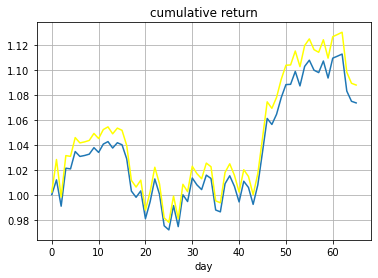

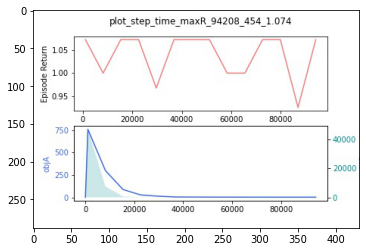

In [120]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
args.env = SingleStockEnv(price_ary = price_ary, tech_ary = tech_ary, if_train=False)
SingleStockEnv(price_ary = price_ary, tech_ary = tech_ary, if_train=False)\
.draw_cumulative_return(self = args.env, _torch = torch)
learning_curve = mpimg.imread('./AgentDQN/SingleStockEnv_0/plot_learning_curve.jpg')
plt.imshow(learning_curve)

# **Part 7: Add Technical Indicators**

Use TA-Lib to add technical indicators

In [121]:
tic_list1 = ['MSFT']
df = yf_datadownload('2020-01-01', '2021-05-01', tic_list1, '1d')
df['MA'] = ta.SMA(df['Close'],14)
df['EMA'] = ta.EMA(df['Close'], timeperiod = 14)
df['avg'] = ta.ADX(df['High'],df['Low'], df['Close'], timeperiod=14)
df['up_band'], df['mid_band'], df['low_band'] = ta.BBANDS(df['Close'], timeperiod =14)
df['Relative'] = ta.RSI(df['Close'],14)
df = df.dropna(axis=0)
print(df.head())
price_ary = df['Adj Close'].values
price_ary = np.reshape(price_ary,newshape=[price_ary.shape[0],1])
tech_ary = df[['MA','EMA','avg','up_band','Relative']].values



[*********************100%***********************]  1 of 1 completed
                  Open        High  ...    low_band   Relative
Date                                ...                       
2020-02-11  190.649994  190.699997  ...  157.985377  70.281141
2020-02-12  185.580002  185.850006  ...  159.151976  70.525366
2020-02-13  183.080002  186.229996  ...  161.219334  68.287103
2020-02-14  183.250000  185.410004  ...  164.744453  69.970337
2020-02-18  185.610001  187.699997  ...  167.868041  71.817019

[5 rows x 13 columns]


# **Part 8: Train, Evaluate and Backtest the Agent**

| GPU id: 0, cwd: ./AgentDQN/SingleStockEnv_0
| Remove history
ID      Step      MaxR |    avgR      stdR       objA      objC |  avgS  stdS
0   1.02e+03      0.99 |
0   1.02e+03      0.99 |    0.99      0.00       0.69      0.06 |    61     0
0   8.19e+03      1.03 |
0   8.19e+03      1.03 |    1.03      0.00       2.19      0.02 |    61     0
0   1.54e+04      1.03 |    1.01      0.00       2.88      0.02 |    61     0
0   2.25e+04      1.03 |
0   2.25e+04      1.03 |    1.03      0.00       3.48      0.05 |    61     0
0   2.97e+04      1.03 |    0.95      0.00       4.10      0.03 |    61     0
0   3.69e+04      1.03 |    0.95      0.00       4.45      0.02 |    61     0
0   4.40e+04      1.03 |    0.95      0.00       4.75      0.02 |    61     0
0   5.12e+04      1.03 |    0.95      0.00       4.97      0.03 |    61     0
0   5.84e+04      1.03 |    0.95      0.00       4.94      0.04 |    61     0
0   6.55e+04      1.03 |    0.95      0.00       5.10      0.02 |    61     0
0   

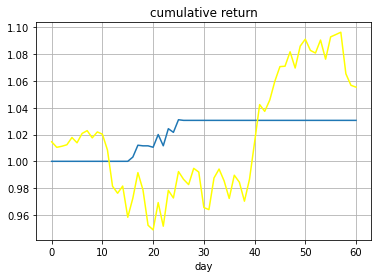

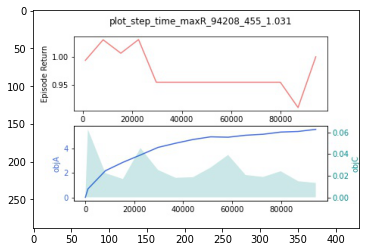

In [123]:
args = Arguments(agent=None, env=None)
args.agent = AgentDQN()
args.env = SingleStockEnv(price_ary = price_ary,target_return = 1.2, tech_ary = tech_ary, if_train=True)
args.env_eval = SingleStockEnv(price_ary = price_ary,target_return = 1.2, tech_ary = tech_ary, if_train=False)
args.net_dim = 2 ** 9 
args.batch_size = 2 ** 8
args.break_step = int(1e5)
train_and_evaluate(args)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
args.env = SingleStockEnv(price_ary = price_ary, tech_ary = tech_ary, if_train=False)
SingleStockEnv(price_ary = price_ary, tech_ary = tech_ary, if_train=False)\
.draw_cumulative_return(self = args.env, _torch = torch)
learning_curve = mpimg.imread('./AgentDQN/SingleStockEnv_0/plot_learning_curve.jpg')
plt.imshow(learning_curve)

# **Part 9: Add More Technical Indicators**


In [113]:
tic_list1 = ['MSFT']
df = yf_datadownload('2020-01-01', '2021-05-01', tic_list1, '1d')
df['MA'] = ta.SMA(df['Close'],14)
df['EMA'] = ta.EMA(df['Close'], timeperiod = 14)
df['avg'] = ta.ADX(df['High'],df['Low'], df['Close'], timeperiod=14)
df['up_band'], df['mid_band'], df['low_band'] = ta.BBANDS(df['Close'], timeperiod =14)
df['Relative'] = ta.RSI(df['Close'],14)
df['cci'] = ta.CCI(df['High'], df['Low'], df['Close'], timeperiod=14)
df['macd'],df['macdsignal'],df['macdhist']=ta.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['willr'] = ta.WILLR(df['High'],df['Low'],df['Close'], timeperiod=14)
df['ppo'] = ta.PPO(df['Close'], fastperiod=12, slowperiod=26, matype=0)
df = df.dropna(axis=0)
print(df.head())
price_ary = df['Adj Close'].values
price_ary = np.reshape(price_ary,newshape=[price_ary.shape[0],1])
tech_ary = df[['MA','EMA','avg','up_band','Relative','cci','macd','macdsignal','macdhist','willr','ppo']].values

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low  ...  macdhist      willr       ppo
Date                                            ...                               
2020-02-20  186.949997  187.250000  181.100006  ... -0.016676 -29.734850  5.420132
2020-02-21  183.169998  183.500000  177.250000  ... -0.639800 -59.655166  4.967456
2020-02-24  167.770004  174.550003  163.229996  ... -1.547069 -72.115022  4.363627
2020-02-25  174.199997  174.839996  167.649994  ... -2.269918 -82.380738  3.583409
2020-02-26  169.710007  173.259995  168.210007  ... -2.520128 -74.736068  2.864645

[5 rows x 19 columns]


# **Part 10: Train, Evaluate and Backtest the Agent Again**

| GPU id: 0, cwd: ./AgentDQN/SingleStockEnv_0
| Remove history
ID      Step      MaxR |    avgR      stdR       objA      objC |  avgS  stdS
0   1.02e+03      1.05 |
0   1.02e+03      1.05 |    1.05      0.00       0.38      0.04 |    60     0
0   8.19e+03      1.08 |
0   8.19e+03      1.08 |    1.08      0.00       2.01      0.04 |    60     0
0   1.54e+04      1.09 |
0   1.54e+04      1.09 |    1.09      0.00       3.24      0.06 |    60     0
0   2.25e+04      1.09 |    1.08      0.00       4.10      0.04 |    60     0
0   2.97e+04      1.10 |
0   2.97e+04      1.10 |    1.10      0.00       4.69      0.05 |    60     0
0   3.69e+04      1.10 |    1.10      0.00       5.11      0.08 |    60     0
0   4.40e+04      1.10 |    1.09      0.00       5.36      0.05 |    60     0
0   5.12e+04      1.10 |    1.09      0.00       5.74      0.02 |    60     0
0   5.84e+04      1.10 |    1.07      0.00       6.14      0.03 |    60     0
0   6.55e+04      1.10 |    1.08      0.00       6.35    

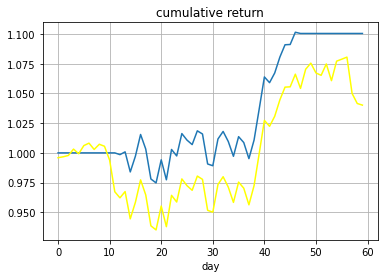

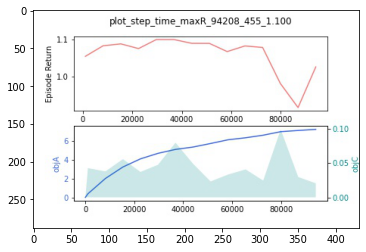

In [115]:
args = Arguments(agent=None, env=None)
args.agent = AgentDQN()
args.env = SingleStockEnv(price_ary = price_ary,target_return = 1.2, tech_ary = tech_ary, if_train=True)
args.env_eval = SingleStockEnv(price_ary = price_ary,target_return = target+1, tech_ary = tech_ary, if_train=False)
args.net_dim = 2 ** 9 
args.batch_size = 2 ** 8
args.break_step = int(1e5)
train_and_evaluate(args)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
args.env = SingleStockEnv(price_ary = price_ary,target_return = target+1, tech_ary = tech_ary, if_train=False)
SingleStockEnv(price_ary = price_ary, tech_ary = tech_ary, if_train=False)\
.draw_cumulative_return(self = args.env, _torch = torch)
learning_curve = mpimg.imread('./AgentDQN/SingleStockEnv_0/plot_learning_curve.jpg')
plt.imshow(learning_curve)

# **Part 11: Experienment on different stock and period(1)**

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low  ...  macdhist      willr       ppo
Date                                         ...                               
2020-02-20  80.657501  81.162498  79.552498  ... -0.187309 -27.680054  1.064725
2020-02-21  79.654999  80.112503  77.625000  ... -0.336194 -56.680054  0.908622
2020-02-24  74.315002  76.044998  72.307503  ... -0.658584 -76.441211  0.459906
2020-02-25  75.237503  75.632500  71.532501  ... -0.995220 -95.254364 -0.184538
2020-02-26  71.632500  74.470001  71.625000  ... -1.086819 -84.132418 -0.589374

[5 rows x 19 columns]
| GPU id: 0, cwd: ./AgentDQN/SingleStockEnv_0
| Remove history
ID      Step      MaxR |    avgR      stdR       objA      objC |  avgS  stdS
0   1.02e+03      0.99 |
0   1.02e+03      0.99 |    0.99      0.00       0.21      0.02 |    60     0
0   8.19e+03      1.02 |
0   8.19e+03      1.02 |    1.02      0.00       2.59      0.05 |    60     0
0

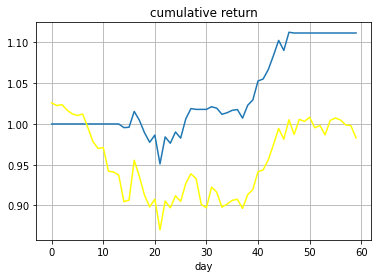

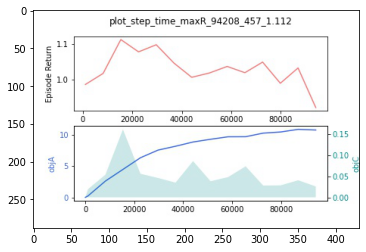

In [125]:
tic_list1 = ['AAPL']
df = yf_datadownload('2020-01-01', '2021-05-01', tic_list1, '1d')
df['MA'] = ta.SMA(df['Close'],14)
df['EMA'] = ta.EMA(df['Close'], timeperiod = 14)
df['avg'] = ta.ADX(df['High'],df['Low'], df['Close'], timeperiod=14)
df['up_band'], df['mid_band'], df['low_band'] = ta.BBANDS(df['Close'], timeperiod =14)
df['Relative'] = ta.RSI(df['Close'],14)
df['cci'] = ta.CCI(df['High'], df['Low'], df['Close'], timeperiod=14)
df['macd'],df['macdsignal'],df['macdhist']=ta.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['willr'] = ta.WILLR(df['High'],df['Low'],df['Close'], timeperiod=14)
df['ppo'] = ta.PPO(df['Close'], fastperiod=12, slowperiod=26, matype=0)
df = df.dropna(axis=0)
print(df.head())
price_ary = df['Adj Close'].values
price_ary = np.reshape(price_ary,newshape=[price_ary.shape[0],1])
tech_ary = df[['MA','EMA','avg','up_band','Relative','cci','macd','macdsignal','macdhist','willr','ppo']].values

args = Arguments(agent=None, env=None)
args.agent = AgentDQN()
args.env = SingleStockEnv(price_ary = price_ary,target_return = 1.2, tech_ary = tech_ary, if_train=True)
args.env_eval = SingleStockEnv(price_ary = price_ary,target_return = 1.2, tech_ary = tech_ary, if_train=False)
args.net_dim = 2 ** 9 
args.batch_size = 2 ** 8
args.break_step = int(1e5)
train_and_evaluate(args)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
args.env = SingleStockEnv(price_ary = price_ary,target_return = 1.2, tech_ary = tech_ary, if_train=False)
SingleStockEnv(price_ary = price_ary, tech_ary = tech_ary, if_train=False)\
.draw_cumulative_return(self = args.env, _torch = torch)
learning_curve = mpimg.imread('./AgentDQN/SingleStockEnv_0/plot_learning_curve.jpg')
plt.imshow(learning_curve)

# **Part 12: Experienment on different stock and period(2)**

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low  ...  macdhist      willr       ppo
Date                                            ...                               
2020-02-20  312.769989  316.320007  296.350006  ...  7.641761  -9.341663  5.743202
2020-02-21  304.190002  305.200012  290.660004  ...  6.111517 -27.513289  6.513136
2020-02-24  270.190002  281.869995  268.000000  ...  3.425122 -59.529747  6.796191
2020-02-25  276.299988  278.790009  257.959991  ...  0.757188 -78.754922  6.838517
2020-02-26  262.059998  275.450012  262.000000  ... -0.686989 -72.167870  7.060229

[5 rows x 19 columns]
| GPU id: 0, cwd: ./AgentDQN/SingleStockEnv_0
| Remove history
ID      Step      MaxR |    avgR      stdR       objA      objC |  avgS  stdS
0   1.02e+03      0.83 |
0   1.02e+03      0.83 |    0.83      0.00       0.96      0.09 |    60     0
0   8.19e+03      1.13 |
0   8.19e+03      1.13 |    1.13      0.00       4.20     

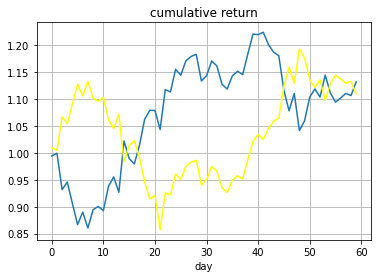

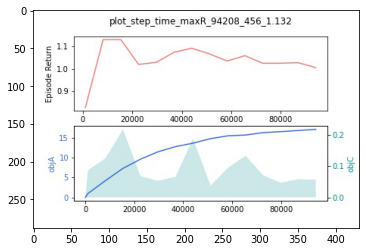

In [129]:
tic_list1 = ['NVDA']
df = yf_datadownload('2020-01-01', '2021-05-01', tic_list1, '1d')
df['MA'] = ta.SMA(df['Close'],14)
df['EMA'] = ta.EMA(df['Close'], timeperiod = 14)
df['avg'] = ta.ADX(df['High'],df['Low'], df['Close'], timeperiod=14)
df['up_band'], df['mid_band'], df['low_band'] = ta.BBANDS(df['Close'], timeperiod =14)
df['Relative'] = ta.RSI(df['Close'],14)
df['cci'] = ta.CCI(df['High'], df['Low'], df['Close'], timeperiod=14)
df['macd'],df['macdsignal'],df['macdhist']=ta.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['willr'] = ta.WILLR(df['High'],df['Low'],df['Close'], timeperiod=14)
df['ppo'] = ta.PPO(df['Close'], fastperiod=12, slowperiod=26, matype=0)
df = df.dropna(axis=0)
print(df.head())
price_ary = df['Adj Close'].values
price_ary = np.reshape(price_ary,newshape=[price_ary.shape[0],1])
tech_ary = df[['MA','EMA','avg','up_band','Relative','cci','macd','macdsignal','macdhist','willr','ppo']].values

args = Arguments(agent=None, env=None)
args.agent = AgentDQN()
args.env = SingleStockEnv(price_ary = price_ary,target_return = 1.2, tech_ary = tech_ary, if_train=True)
args.env_eval = SingleStockEnv(price_ary = price_ary,target_return = 1.2, tech_ary = tech_ary, if_train=False)
args.net_dim = 2 ** 9 
args.batch_size = 2 ** 8
args.break_step = int(1e5)
train_and_evaluate(args)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
args.env = SingleStockEnv(price_ary = price_ary, tech_ary = tech_ary, if_train=False)
SingleStockEnv(price_ary = price_ary, tech_ary = tech_ary, if_train=False)\
.draw_cumulative_return(self = args.env, _torch = torch)
learning_curve = mpimg.imread('./AgentDQN/SingleStockEnv_0/plot_learning_curve.jpg')
plt.imshow(learning_curve)

# **Part 13: Experienment on different stock and period(3)**

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low  ...  macdhist       willr       ppo
Date                                         ...                                
2020-02-20  42.700001  43.599998  42.459999  ...  0.654133  -15.144165 -1.594182
2020-02-21  42.549999  42.570000  41.830002  ...  0.594119  -35.576913 -0.816349
2020-02-24  40.500000  40.549999  39.480000  ...  0.369663 -100.000000 -0.633390
2020-02-25  39.540001  39.619999  36.000000  ...  0.011581  -97.500018 -0.858672
2020-02-26  36.270000  36.439999  34.189999  ... -0.327272  -99.681163 -1.336446

[5 rows x 19 columns]
| GPU id: 0, cwd: ./AgentDQN/SingleStockEnv_0
| Remove history
ID      Step      MaxR |    avgR      stdR       objA      objC |  avgS  stdS
0   1.02e+03      1.00 |
0   1.02e+03      1.00 |    1.00      0.00       0.08      0.00 |    60     0
0   8.19e+03      1.00 |
0   8.19e+03      1.00 |    1.00      0.00       0.12      0.01 |    60 

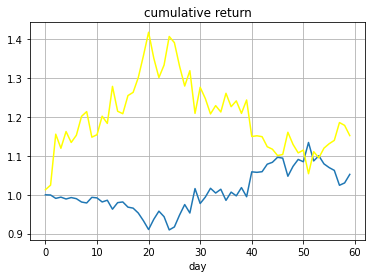

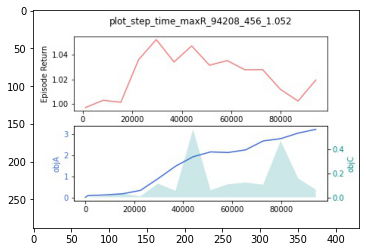

In [127]:
tic_list1 = ['OXY']
df = yf_datadownload('2020-01-01', '2021-05-01', tic_list1, '1d')
df['MA'] = ta.SMA(df['Close'],14)
df['EMA'] = ta.EMA(df['Close'], timeperiod = 14)
df['avg'] = ta.ADX(df['High'],df['Low'], df['Close'], timeperiod=14)
df['up_band'], df['mid_band'], df['low_band'] = ta.BBANDS(df['Close'], timeperiod =14)
df['Relative'] = ta.RSI(df['Close'],14)
df['cci'] = ta.CCI(df['High'], df['Low'], df['Close'], timeperiod=14)
df['macd'],df['macdsignal'],df['macdhist']=ta.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['willr'] = ta.WILLR(df['High'],df['Low'],df['Close'], timeperiod=14)
df['ppo'] = ta.PPO(df['Close'], fastperiod=12, slowperiod=26, matype=0)
df = df.dropna(axis=0)
print(df.head())
price_ary = df['Adj Close'].values
price_ary = np.reshape(price_ary,newshape=[price_ary.shape[0],1])
tech_ary = df[['MA','EMA','avg','up_band','Relative','cci','macd','macdsignal','macdhist','willr','ppo']].values

args = Arguments(agent=None, env=None)
args.agent = AgentDQN()
target = price_ary[-1]/price_ary[0]
args.env = SingleStockEnv(price_ary = price_ary,target_return = 1.2, tech_ary = tech_ary, if_train=True)
args.env_eval = SingleStockEnv(price_ary = price_ary,target_return = 1.2, tech_ary = tech_ary, if_train=False)
args.net_dim = 2 ** 9 
args.batch_size = 2 ** 8
args.break_step = int(1e5)
train_and_evaluate(args)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
args.env = SingleStockEnv(price_ary = price_ary,target_return = 1.2, tech_ary = tech_ary, if_train=False)
SingleStockEnv(price_ary = price_ary, tech_ary = tech_ary, if_train=False)\
.draw_cumulative_return(self = args.env, _torch = torch)
learning_curve = mpimg.imread('./AgentDQN/SingleStockEnv_0/plot_learning_curve.jpg')
plt.imshow(learning_curve)